In [1]:
import numpy as np
import mylibrary.nnlib as tnn
import matplotlib.pyplot as plt
import copy

from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn

import mylibrary.datasets as datasets
import prunelib
from tqdm import tqdm
import random

import pickle
import copy

In [23]:
mnist = datasets.MNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

In [24]:
train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [25]:
xx = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
yy = torch.LongTensor(train_label_)

## Compare

In [26]:
input_dim = 784
output_dim = 10

In [27]:
"""
settings:
1,2,3 -> net = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)

4,5 -> net = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)

6, 7 -> net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
8, 9 -> net = nn.Sequential(
    nn.Linear(784, 400),
    nn.ReLU(),
    nn.Linear(400, 300),
    nn.ReLU(),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
"""
print("Nets")

Nets


In [28]:
config0 = [256, 128, 64]
config1 = [100, 100, 100]
config2 = [200, 100, 100, 100]
config3 = [400, 300, 200, 100]

layer_dims = config0

In [29]:
def get_mlp(config, batch_norm=False, final_activation=None):
    config = [input_dim]+config
    layers = []
    for i in range(len(config)-1):
        l = nn.Linear(config[i], config[i+1])
        layers.append(l)
        if batch_norm:
            layers.append(nn.BatchNorm1d(config[i+1]))
        layers.append(nn.ReLU())
            
    l = nn.Linear(config[-1], output_dim)
    layers.append(l)
    if final_activation:
        layers.append(final_activation)
    return nn.Sequential(*layers)

In [30]:
expindx = 8

In [31]:
net = get_mlp(config0, batch_norm=True)
net

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=10, bias=True)
)

In [32]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [33]:
# for epoch in range(60):
#     yout = net(xx)

#     loss = criterion(yout, yy)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     error = float(loss)
#     print(epoch, 'Error = ', error)
    
#     with torch.no_grad():
#         yout = net(xx)
#         out = torch.argmax(yout, axis=1)
#         acc = (out.data.numpy() == np.array(train_label_)).astype(np.float).mean()
#         print("Accuracy: ", acc)

In [34]:
# list(net._modules.items())

In [35]:
# torch.save({"model":net.state_dict(), "optimizer":optimizer.state_dict()},
#           "./mnist_100_mlp_bn.pth")

In [36]:
checkpoint = torch.load("./mnist_100_mlp_bn.pth")
net.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

In [37]:
# net = net.train()

## Convert BN network to Linear only

In [38]:
def remove_batchnorm(net, layer_dims):
    net_ = get_mlp(layer_dims)
    count = 0
    for name, module in list(net._modules.items()):
        if isinstance(module, nn.BatchNorm1d):
            count += 1
            
    i = 0
    j = 0
    print(count)
    for _ in range(count):
        gamma = net[i+1].weight.data
        beta = net[i+1].bias.data
        mean = net[i+1].running_mean
        var = torch.sqrt(net[i+1].running_var)

        w = net[i].weight.data
        b = net[i].bias.data

        newW = (gamma/var).reshape(-1, 1)*w
        newb = beta + gamma/var*(b-mean)

        net_[j].weight.data *= 0.
        net_[j].bias.data *= 0

        net_[j].weight.data += newW
        net_[j].bias.data += newb

        i = i + 3
        j = j + 2
        
    net_[-1].weight.data *= 0
    net_[-1].bias.data *= 0
    net_[-1].weight.data += net[-1].weight.data
    net_[-1].bias.data += net[-1].bias.data
    
    return  net_

In [39]:
net_ = remove_batchnorm(net, layer_dims)
net_

3


Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
)

In [40]:
## accuracy of new network
# yout = net.eval()(xx)
yout = net_(xx)
out = torch.argmax(yout, axis=1)
acc = (out.data.numpy() == np.array(train_label_)).astype(np.float).mean()
print("Accuracy: ", acc)

Accuracy:  0.9959166666666667


## Oracle Pruning Modified

In [43]:
class Importance_TaylorFO_Modified_BN(prunelib.Importance):
    
    def __init__(self, net, criterion, config=None):
        self.net = net
        self.config = config
        self.criterion = criterion
        
        self.activations = {}
        self.gradients = {}
        self.forward_hook = {}
        self.backward_hook = {}
        self.keys = []
        
        pass

    def add_hook(self):
        self.activations = {}
        self.gradients = {}
        self.forward_hook = {}
        self.backward_hook = {}
        self.keys = []
        
        modules = list(self.net._modules.items())
        for name, module in modules:
            if isinstance(module, torch.nn.BatchNorm1d):
#             if isinstance(module, torch.nn.Linear):
                hook = module.register_backward_hook(self.capture_gradients)
                self.backward_hook[module] = hook
                hook = module.register_forward_hook(self.capture_inputs)
                self.forward_hook[module] = hook
                
                self.activations[module] = None
                self.gradients[module] = None
                self.keys.append(module)
                
        for name, module in reversed(modules):
            if isinstance(module, torch.nn.Linear):
                hook = module.register_backward_hook(self.capture_gradients)
                self.backward_hook[module] = hook
                hook = module.register_forward_hook(self.capture_inputs)
                self.forward_hook[module] = hook
                
                self.activations[module] = None
                self.gradients[module] = None
                self.keys.append(module)
                break
                
    def remove_hook(self):
        for module in self.keys:
            hook = self.forward_hook[module]
            hook.remove()
            hook = self.backward_hook[module]
            hook.remove()
    
    def capture_inputs(self, module, inp, out):
        self.activations[module] = out.data
        
    def capture_gradients(self, module, gradi, grado):
        self.gradients[module] = grado[0]
        
    def gather_inputs_gradients(self, x, t):
        self.add_hook()

        self.net.zero_grad()
        y = self.net(x)
        error = self.criterion(y,t)
        error.backward()
        
        self.remove_hook()
        return
    
    
    def compute_significance(self, x, t, config=None, normalize=True, layerwise_norm=False):
        self.gather_inputs_gradients(x, t)
        
        if config is None:
            if self.config is None:
                raise ValueError("config is not known. Please specify the config.") 
            else:
                config = self.config
        
        ## compute importance score
        importance = []
        if config["grad_rescale"]:
            scaler = torch.norm(self.gradients[self.keys[-1]], p=2, dim=1, keepdim=True) + 1e-5

        for module in self.keys[:-1]:
            z = self.activations[module] * self.gradients[module]
            if config["grad_rescale"]:
                z = z / scaler
            if config["imp_norm"] == "abs":
                z = z.abs()
            elif config["imp_norm"] == "sq":
                z = z.pow(2)

            z = z.sum(dim=0).abs()
            if not config["allow_linear"]:
                apnz = torch.sum(self.activations[module] > 0., dim=0, dtype=torch.float)
                z = z*(1-apnz) * 4 ## tried on desmos.

            if layerwise_norm:
                z = z / torch.norm(z, p=2)

            importance.append(z)

        if normalize:
            sums = 0
            count = 0
            for imp in importance:
                sums += imp.sum()
                count += len(imp)
            divider = sums/count ## total importance is number of neurons
            for i in range(len(importance)):
                importance[i] = importance[i]/divider
            
        
#         del self.activations[self.keys[-1]]
        self.activations = {}
        self.gradients = {}
        self.forward_hook = {}
        self.backward_hook = {}
        
        return importance
    
    def get_aponz(self, std=True):
        if len(self.activations) < 1:
            print("Activation has not been accumulated.. run compute_significance function")
            return
        aponz = []
        std = []
        for module in self.keys[:-1]:
            apnz = torch.sum(self.activations[module] > 0., dim=0, dtype=torch.float)
            aponz.append(apnz)
            if std:
                std.append(self.activations[module].std())
        
        if std:
            return aponz, std
        return aponz

        

class Importance_Molchanov_BN(prunelib.Importance):

    def __init__(self, net, criterion):
        self.net = net
        self.criterion = criterion
        self.keys = []
        for name, module in list(self.net._modules.items()):
            if isinstance(module, torch.nn.BatchNorm1d):
                self.keys.append(module)
        
    def compute_significance(self, x, t, normalize=True, batch_size=32):

        importance = [0]*len(self.keys)
        bstrt = list(range(0, len(x), batch_size))
        bstop = bstrt[1:]+[len(x)]
        for i in tqdm(range(len(bstrt))):
            self.net.zero_grad()
            y = self.net(x[bstrt[i]:bstop[i]])
            error = self.criterion(y,t[bstrt[i]:bstop[i]])
            error.backward()
        
            ## compute importance for each input
            for j, module in enumerate(self.keys):
                z = (module.weight.data*module.weight.grad +\
                     module.bias.data*module.bias.grad).pow(2)
                importance[j] += z
                
        ## compute mean
        for i, module in enumerate(self.keys):
            importance[i] = importance[i]/len(bstrt) 

        if normalize:
            sums = 0
            count = 0
            for imp in importance:
                sums += imp.sum()
                count += len(imp)
            divider = sums/count ## total importance is number of neurons
            for i in range(len(importance)):
                importance[i] = importance[i]/divider
            
        return importance

## Define pruning function

In [44]:
class Pruner():
    
    def __init__(self, net, prune_mask=None):
        self.net = net
        self.keys = []
        self.prune_mask = {}
        self.forward_hook = {}
        
        self.activations = []
        
        for name, module in list(self.net._modules.items()):
            if isinstance(module, torch.nn.Linear):
                self.keys.append(module)

        if prune_mask is not None:
            self.add_prune_mask(prune_mask)
        self.remove_hook()
        
    def add_prune_mask(self, prune_mask):
        for module, pm in zip(self.keys[:-1], prune_mask):
            self.prune_mask[module] = pm.type(torch.float)
        self.prune_mask[self.keys[-1]] = torch.ones(self.keys[-1].out_features, dtype=torch.float)
            
        
    def prune_neurons(self, module, inp, out):
        mask = self.prune_mask[module]
        output = out*mask
        
        self.activations.append(output)
        return output
        
    def forward(self, x, prune_mask=None):
        if prune_mask:
            self.add_prune_mask(prune_mask)
            if len(self.forward_hook) == 0:
                self.add_hook()
        
        y = self.net(x)
        self.remove_hook()
        return y
        
        
    def add_hook(self):
        if len(self.forward_hook) > 0:
            self.remove_hook()
            
        self.forward_hook = {}
        for name, module in list(self.net._modules.items()):
            if isinstance(module, torch.nn.Linear):
                hook = module.register_forward_hook(self.prune_neurons)
                self.forward_hook[module] = hook
        return
        
    def remove_hook(self):       
        for module in self.forward_hook.keys():
            hook = self.forward_hook[module]
            hook.remove()
        self.forward_hook = {}
        self.prune_mask = {}
        self.activations = []
        return

## comparing for all

In [45]:
methods = []
classes = []

## taylor fo modified
methods = prunelib.taylorfo_mode_list[:3]
classes += [Importance_TaylorFO_Modified_BN(net, criterion, config=prunelib.taylorfo_mode_config[method]) for method in methods]


## Molchanov_group, APnZ, Magnitude
methods += ["Molchanov_group", "Molchanov_BN", "APnZ"]
classes += [
            prunelib.Importance_Molchanov_2019(net, criterion),
            Importance_Molchanov_BN(net, criterion),
            prunelib.Importance_APoZ(net, criterion),
            ]

In [46]:
## gather all importances
importances = []
for i in range(len(methods)):
    print(methods[i])
    imp = classes[i].compute_significance(xx, yy)
    importances.append(imp)

taylorfo
taylorfo_abs
taylorfo_sq


  0%|          | 7/1875 [00:00<00:27, 67.48it/s]

Molchanov_group


  1%|          | 15/1875 [00:00<00:12, 144.11it/s]

Molchanov_BN


100%|██████████| 1875/1875 [00:19<00:00, 97.58it/s] 


APnZ


In [1]:
xs = list(range(1, 401, 5))

## Prune once without fine tuning

In [48]:
## compute new loss and deviation
loss_lol = []
deviation_lol = []
accuracy_lol = []

pnet = Pruner(net)
yout_normal = net.forward(xx).data.cpu()

for i in range(len(methods)):
    print(methods[i])

    losses = []
    deviations = []
    accuracies = []
    importance = importances[i]
#     for num in tqdm(range(1, 401)):
    for num in tqdm(xs):
        pmask = prunelib.get_pruning_mask(importance, num_prune=num)
        yout_prune = pnet.forward(xx, prune_mask=pmask).data.cpu()
        new_err = criterion(yout_prune, yy)
        deviation = ((yout_prune-yout_normal)**2).mean()
        out = torch.argmax(yout_prune, axis=1)
        acc = (out.data.numpy() == np.array(train_label_)).astype(np.float).mean()
        
        losses.append(new_err)
        deviations.append(deviation)
        accuracies.append(acc)
        
    loss_lol.append(losses)
    deviation_lol.append(deviations)
    accuracy_lol.append(accuracies)

  0%|          | 0/80 [00:00<?, ?it/s]

taylorfo


  0%|          | 0/80 [00:00<?, ?it/s]

taylorfo_abs


  0%|          | 0/80 [00:00<?, ?it/s]

taylorfo_sq


  0%|          | 0/80 [00:00<?, ?it/s]

Molchanov_group


  0%|          | 0/80 [00:00<?, ?it/s]

Molchanov_BN


  0%|          | 0/80 [00:00<?, ?it/s]

APnZ


100%|██████████| 80/80 [01:45<00:00,  1.32s/it]


In [57]:
methods_ = copy.deepcopy(methods)
# classes_ = copy.deepcopy(classes)
# importances_ = copy.deepcopy(importances)

loss_lol_ = copy.deepcopy(loss_lol)
deviation_lol_ = copy.deepcopy(deviation_lol)
accuracy_lol_ = copy.deepcopy(accuracy_lol)

In [58]:
net__ = net
net = net_
net_ = net__
del(net__)

In [59]:
net

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
)

## For BN equivalent nonBN networks

In [60]:
methods = []
classes = []

## taylor fo modified
methods = prunelib.taylorfo_mode_list[:3]
classes += [prunelib.Importance_TaylorFO_Modified(net, criterion, config=prunelib.taylorfo_mode_config[method]) for method in methods]


## Molchanov_group, APnZ, Magnitude
methods += ["Molchanov_group", "APnZ"]
classes += [
            prunelib.Importance_Molchanov_2019(net, criterion),
            prunelib.Importance_APoZ(net, criterion),
            ]

In [61]:
## gather all importances
importances = []
for i in range(len(methods)):
    print(methods[i])
    imp = classes[i].compute_significance(xx, yy)
    importances.append(imp)

taylorfo
taylorfo_abs
taylorfo_sq


  2%|▏         | 35/1875 [00:00<00:05, 349.52it/s]

Molchanov_group


100%|██████████| 1875/1875 [00:05<00:00, 319.77it/s]


APnZ


In [62]:
## compute new loss and deviation
loss_lol = []
deviation_lol = []
accuracy_lol = []

pnet = Pruner(net)
yout_normal = net.forward(xx).data.cpu()

for i in range(len(methods)):
    print(methods[i])

    losses = []
    deviations = []
    accuracies = []
    importance = importances[i]
#     for num in tqdm(range(1, 401)):
    for num in tqdm(xs):
        pmask = prunelib.get_pruning_mask(importance, num_prune=num)
        yout_prune = pnet.forward(xx, prune_mask=pmask).data.cpu()
        new_err = criterion(yout_prune, yy)
        deviation = ((yout_prune-yout_normal)**2).mean()
        out = torch.argmax(yout_prune, axis=1)
        acc = (out.data.numpy() == np.array(train_label_)).astype(np.float).mean()
        
        losses.append(new_err)
        deviations.append(deviation)
        accuracies.append(acc)
        
    loss_lol.append(losses)
    deviation_lol.append(deviations)
    accuracy_lol.append(accuracies)

  0%|          | 0/80 [00:00<?, ?it/s]

taylorfo


  0%|          | 0/80 [00:00<?, ?it/s]

taylorfo_abs


  0%|          | 0/80 [00:00<?, ?it/s]

taylorfo_sq


  0%|          | 0/80 [00:00<?, ?it/s]

Molchanov_group


  0%|          | 0/80 [00:00<?, ?it/s]

APnZ


100%|██████████| 80/80 [00:30<00:00,  2.59it/s]


### Plot all together

Text(0, 0.5, 'Loss')

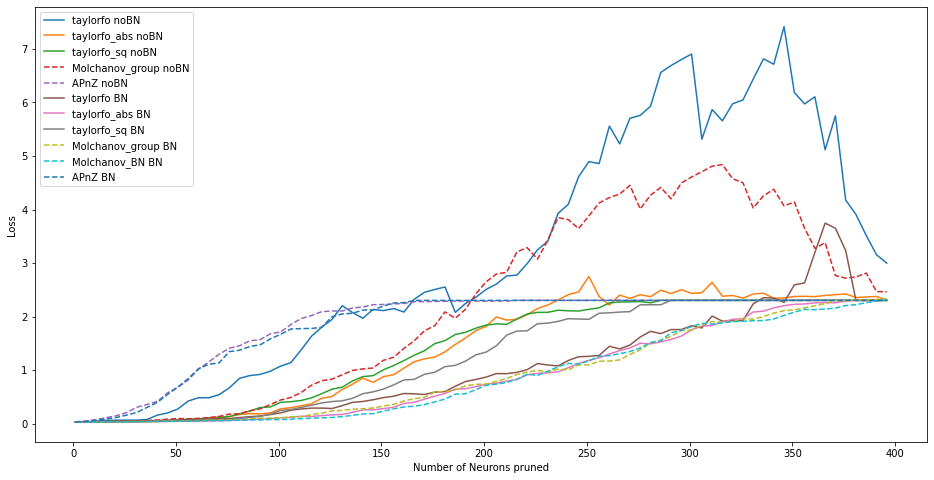

In [66]:
%matplotlib inline
plt.figure(figsize=(16, 8))
for i in range(len(methods)):
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    plt.plot(xs, loss_lol[i], label=methods[i]+" noBN", linestyle=ls)
    
for i in range(len(methods_)):
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    plt.plot(xs, loss_lol_[i], label=methods_[i]+" BN", linestyle=ls)
    
plt.legend()
plt.xlabel("Number of Neurons pruned")
plt.ylabel("Loss")
# plt.savefig(f"plt_05_MNIST_prune_BN_v0_loss_{expindx}_all.svg")

Text(0, 0.5, 'Squared Deviation')

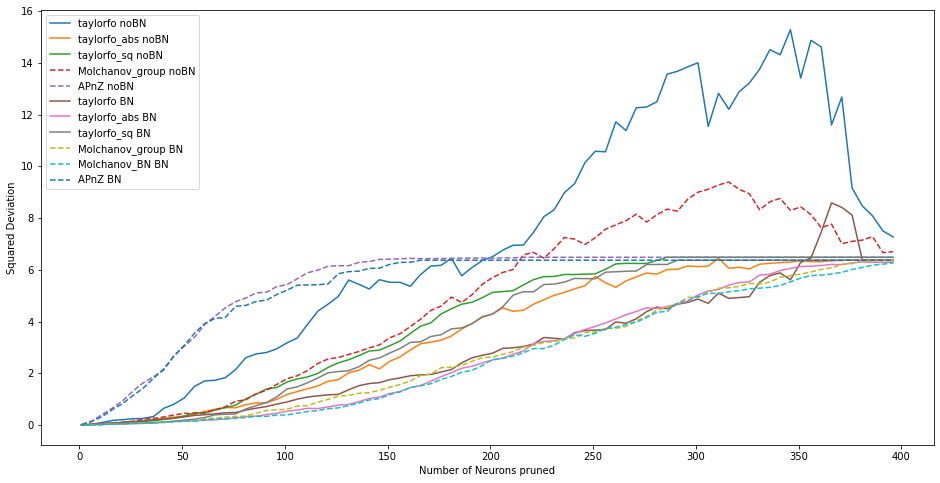

In [67]:
%matplotlib inline
plt.figure(figsize=(16, 8))
for i in range(len(methods)):
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    plt.plot(xs, deviation_lol[i], label=methods[i]+" noBN", linestyle=ls)
    
for i in range(len(methods_)):
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    plt.plot(xs, deviation_lol_[i], label=methods_[i]+" BN", linestyle=ls)
    
plt.legend()
plt.xlabel("Number of Neurons pruned")
plt.ylabel("Squared Deviation")
# plt.savefig(f"plt_05_MNIST_prune_BN_v0_deviation_{expindx}_all.svg")

Text(0, 0.5, 'Accuracy')

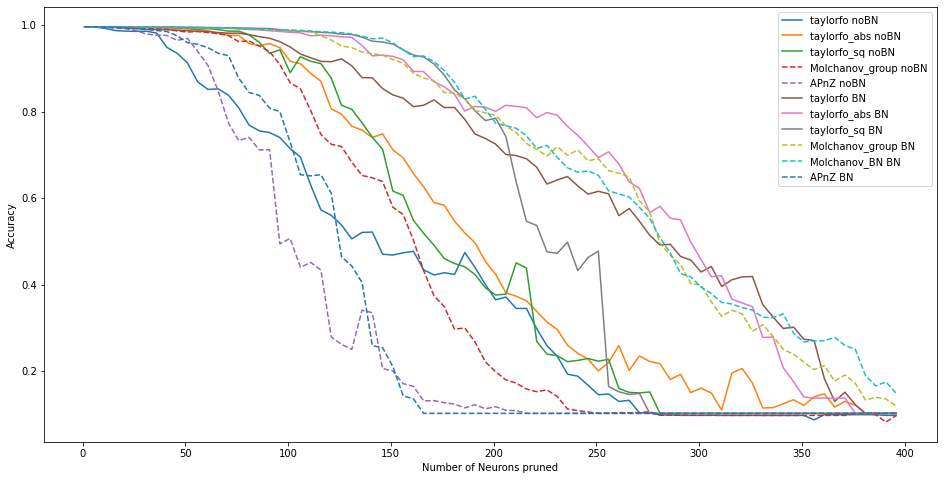

In [68]:
%matplotlib inline
plt.figure(figsize=(16, 8))
for i in range(len(methods)):
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    plt.plot(xs, accuracy_lol[i], label=methods[i]+" noBN", linestyle=ls)
    
for i in range(len(methods_)):
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    plt.plot(xs, accuracy_lol_[i], label=methods_[i]+" BN", linestyle=ls)
    
plt.legend()
plt.xlabel("Number of Neurons pruned")
plt.ylabel("Accuracy")
# plt.savefig(f"plt_05_MNIST_prune_BN_v0_accuracy_{expindx}_all.svg")